# Init

In [1]:
!nvidia-smi

Thu Dec 22 13:22:34 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.23                 Driver Version: 370.23                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:04:00.0     Off |                  N/A |
| 23%   29C    P8    24W / 250W |  11707MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    On   | 0000:05:00.0     Off |                  N/A |
| 23%   30C    P8    23W / 250W |      0MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [170]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import re, os, sys
tf.__version__

def create_session():
    config = tf.ConfigProto(log_device_placement=True, graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    return tf.InteractiveSession(config=config)

# Setup utilities to parse __LOG_MEMORY__ statements in command-line
#tensor_allocation_regex = re.compile(r"allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")
# allocated_bytes: 2400000 allocator_name: "cpu"
tensor_allocation_regex = re.compile("""MemoryLogTensorAllocation.*?step_id: (?P<step_id>[-0123456789]+).*kernel_name: \"(?P<kernel_name>[^"]+)\".*?allocated_bytes: (?P<allocated_bytes>\d+).*allocator_name: \"(?P<allocator_name>[^"]+)\".*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")   
tensor_output_regex_no_bytes = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*timestamp (?P<timestamp>\d+)""")   
tensor_deallocation_regex = re.compile(r"allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")

#"MemoryLogStep { step_id: 2 handle: "->/group_deps/0/;1" } timestamp 5673393661785237'"
tensor_logstep_regex = re.compile("""MemoryLogStep.*?step_id: (?P<step_id>[-0123456789]+).*?.*timestamp (?P<timestamp>\d+)""")

def _parse_logline(l):
    # There are 4 kinds of lines with __LOG_MEMORY__ tag
    # MemoryLogTensorDeallocation, MemoryLogTensorAllocation, MemoryLogStep,
    #
    # Example lines for debugging:
    # MemoryLogTensorDeallocation
    # 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cpu" } timestamp 5143420588459765

    # MemoryLogTensorAllocation
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 has_single_reference: true ptr: 29496256 } } } timestamp 5143420588526034

    # MemoryLogStep
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 1 handle: "->Print:0//0/;0" } timestamp 5143420588718348

    # MemoryLogTensorOutput
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Const" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 ptr: 29496256 } } } timestamp 5143420588932740
     
    # some weird initialization step 
    # if "step_id: -6" in l:
    #    return {}
    
    if 'MemoryLogTensorOutput' in l:
        m = tensor_output_regex.search(l)
        # some Shape lines are missing bytes info, ie # I 5162643141.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 5 kernel_name: "gradients/Shape" tensor { dtype: DT_INT32 shape { dim { } } } } timestamp 5162643141310124
        if not m:
            m = tensor_output_regex_no_bytes.search(l)

        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorOutput"
            
    elif 'MemoryLogTensorAllocation' in l:
        m = tensor_allocation_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorAllocation"
    elif 'MemoryLogTensorDeallocation' in l:
        m = tensor_deallocation_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorDeallocation"
    elif 'MemoryLogStep' in l:
        m = tensor_logstep_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogStep"
    else:
        assert False, "Unknown log line"
        
    if not "allocation_id" in d:
        d["allocation_id"] = "-1"

    d["line"] = l
    d["timestamp"] = int(d["timestamp"])
    return d

def memory_timeline(output):
    def get_alloc_names(allocation_id):
        for entry in allocation_map[allocation_id]:
            kernel_name = entry.get("kernel_name", "unknown")
            if not "unknown" in kernel_name.lower():
                return kernel_name+"("+allocation_id+")"
        return "("+allocation_id+")"

    def get_alloc_bytes(allocation_id):
        for entry in allocation_map[allocation_id]:
            if "allocated_bytes" in entry:
                return entry["allocated_bytes"]
        return "0"

    def get_alloc_type(allocation_id):
        for entry in allocation_map[allocation_id]:
            if "allocator_name" in entry:
                return entry["allocator_name"]
        return "0"

    parsed_lines = [_parse_logline(l) for l in output.split("\n") if '__LOG_MEMORY__' in l]
    parsed_lines.sort(key=lambda l: l["timestamp"])
    first_timestamp = parsed_lines[0]["timestamp"]

    # Tensors that are output have two records (allocation and output)
    # since output comes after, overwrite allocation_map with output
    # info (it has kernel_name)
    allocation_map = {} # map of allocation_id->parsed_logline of allocation
    double_records = {} # map of ids which have both allocation and output
    for line in parsed_lines:
        if line["type"] == "MemoryLogTensorAllocation" or line["type"] == "MemoryLogTensorOutput":
            allocation_map.setdefault(line["allocation_id"], []).append(line)

    result = []
    for line in parsed_lines:
        assert "allocation_id" in line
        alloc_names = get_alloc_names(line["allocation_id"])
        alloc_bytes = get_alloc_bytes(line["allocation_id"])
        alloc_type = get_alloc_type(line["allocation_id"])
        if line["type"] == "MemoryLogTensorDeallocation":
            alloc_bytes = "-" + alloc_bytes
        result.append((line["timestamp"]-first_timestamp, alloc_names, alloc_bytes, alloc_type))
    return result


def print_memory_timeline(stderr, gpu_only=False):
    total_memory = 0
    for record in memory_timeline(stderr):
        timestamp, kernel_name, allocated_bytes, allocator_type = record
        allocated_bytes = int(allocated_bytes)
        if gpu_only:
            if not allocator_type.startswith("gpu"):
                continue
        if abs(allocated_bytes)<1000:
            continue  # ignore small allocations
        total_memory += allocated_bytes
        print("%9d %40s %11d %11d %s"%(timestamp, kernel_name, allocated_bytes, total_memory, allocator_type))

def plot_memory_timeline(stderr, gpu_only=False):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        if gpu_only:
            if not record[3].startswith("gpu"):
                continue
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += int(record[2])
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)
    
    
run_metadata = tf.RunMetadata()
def summarize(run_metadata=run_metadata):
    ss = tf.contrib.stat_summarizer.NewStatSummarizer(tf.get_default_graph().as_graph_def().SerializeToString())
    ss.ProcessStepStatsStr(run_metadata.step_stats.SerializeToString())
    print(ss.GetOutputString())
    
def printops(ops):
    print([op.name for op in ops])
    
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
def sessrun(*args, **kwargs):
    sess = create_session()
    sess.run(tf.global_variables_initializer())
    kwargs["run_metadata"] = run_metadata
    kwargs["options"] = run_options
    return sess.run(*args, **kwargs)

import tensorflow.contrib.graph_editor as ge
def run_after(a_tensor, b_tensor):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a_tensor.op, [b_tensor.op])

import os
import sys

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output

redirect=FDRedirector(STDERR)
stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect.start();
    yield
    stderr = redirect.stop()
    
def open_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<BEGIN>"))
    
def close_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<END>"))
    
def grab_output(tag, filename="/tmp/jupyter.txt"):
    s = open(filename).read()
    opening_tag = tag+"<BEGIN>"
    ending_tag = tag+"<END>"
    starting_pos = s.rfind(opening_tag)
    ending_pos = s.rfind(ending_tag)
    return s[starting_pos:ending_pos]

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5486287639689742599, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11992055808
 locality {
   bus_id: 1
 }
 incarnation: 14735317464372770834
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:05:00.0"]

# Allocate 60% of memory in one session

In [181]:
tf.reset_default_graph()
var_size = 1000000/4
tf_vars = []
num_vars = 10
for i in range(num_vars):
    with tf.device("/gpu:0"):
        actual_size = var_size+i*10000/4
        tf_vars.append(tf.Variable(tf.zeros_initializer(shape=(actual_size,), dtype=tf.float32)))
        
import tensorflow.contrib.graph_editor as ge
def run_after(a, b):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a, [b])

for i in range(1, num_vars):
    run_after(tf_vars[i].initializer, tf_vars[i-1].initializer)
init_op = tf.group(*[v.initializer for v in tf_vars])

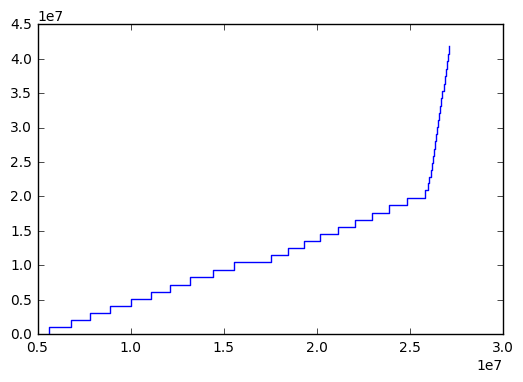

In [182]:
sess = create_session()
open_tag('mem')
sess.run(init_op)
close_tag('mem')
stderr=grab_output('mem')
plot_memory_timeline(stderr, True)

In [185]:
print_memory_timeline(stderr, True)

  5617369                               zeros(136)     1000192     1000192 gpu_bfc
  6772893                             zeros_1(137)     1010176     2010368 gpu_bfc
  7827603                             zeros_2(138)     1020160     3030528 gpu_bfc
  8877909                             zeros_3(139)     1030144     4060672 gpu_bfc
 10045318                             zeros_4(140)     1040128     5100800 gpu_bfc
 11084386                             zeros_5(141)     1050112     6150912 gpu_bfc
 12115295                             zeros_6(142)     1060096     7211008 gpu_bfc
 13180698                             zeros_7(143)     1070080     8281088 gpu_bfc
 14417775                             zeros_8(144)     1080064     9361152 gpu_bfc
 15552212                             zeros_9(145)     1090048    10451200 gpu_bfc
 17554728                               zeros(136)     1000192    11451392 gpu_bfc
 18450243                             zeros_1(137)     1010176    12461568 gpu_bfc
 193

In [172]:
stderr

''

In [6]:
print_memory_timeline(stderr)

5673393648605456                        Variable_1/Assign    -2400000    -2400000
5673393656787488                                <unknown>     4194304     1794304
5673393657308740                                <unknown>    -4194304    -2400000
5673393658231311                        Variable_2/Assign    -2400000    -4800000
5673393659455275                                <unknown>    -4194304    -8994304
5673393660251868                                <unknown>     2400000    -6594304
5673393660329886                                <unknown>    -2400000    -8994304
5673393661524035                                    zeros    -2400000   -11394304
5673393685583929                                <unknown>     2400000    -8994304
5673393685667151                                <unknown>    -2400000   -11394304
5673393685891235                                    zeros     2400000    -8994304
5673393687330275                                <unknown>     2400000    -6594304
5673393687389556

In [9]:
stderr

'mem<BEGIN>[1]\nI 5673393643.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Print" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 2 ptr: 71433760 } } } timestamp 5673393643687045\nI 5673393643.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 5 step 1 _send_Print_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=5079634328368980445, tensor_name="Print:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Print)\nI 5673393643.000000 file tensorflow/core/common_runtime/rendezvous_mgr.cc:42] IntraProcessRendezvous Send 0x4422080 /job:localhost/replica:0/task:0/cpu:0;467e7c82335021dd;/job:localhost/replica:0/task:0/cpu:0;Print:0;0:0\nI 5673393643.000000 file tensorflow/core/common_run

In [75]:
stderr2 = 'mem<BEGIN>[1]\nI 5673393643.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Print" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 2 ptr: 71433760 } } } timestamp 5673393643687045\nI 5673393643.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 5 step 1 _send_Print_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=5079634328368980445, tensor_name="Print:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Print)\nI 5673393643.000000 file tensorflow/core/common_runtime/rendezvous_mgr.cc:42] IntraProcessRendezvous Send 0x4422080 /job:localhost/replica:0/task:0/cpu:0;467e7c82335021dd;/job:localhost/replica:0/task:0/cpu:0;Print:0;0:0\nI 5673393643.000000 file tensorflow/core/common_runtime/rendezvous_mgr.cc:115] IntraProcessRendezvous Recv 0x4422080 /job:localhost/replica:0/task:0/cpu:0;467e7c82335021dd;/job:localhost/replica:0/task:0/cpu:0;Print:0;0:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable_2: (Variable)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable_1: (Variable)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable: (Variable)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable/Assign: (Assign)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable_1/Assign: (Assign)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Variable_2/Assign: (Assign)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] group_deps: (NoOp)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] zeros_2: (Const)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] zeros_1: (Const)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] zeros: (Const)/job:localhost/replica:0/task:0/gpu:0\nI 5673393645.000000 file tensorflow/core/common_runtime/simple_graph_execution_state.cc:279] BuildGraph\nI 5673393645.000000 file tensorflow/core/graph/graph_partition.cc:1049] Added send/recv: controls=0, data=0\nI 5673393645.000000 file tensorflow/core/common_runtime/function.cc:457] Graph Initial #nodes 12 #edges 19\nI 5673393645.000000 file tensorflow/core/common_runtime/function.cc:457] Graph ReCopy #nodes 12 #edges 20\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 3:0 -> 4:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 2:0 -> 4:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 6:0 -> 7:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 5:0 -> 7:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 9:0 -> 10:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 8:0 -> 10:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 3:0 -> 4:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 2:0 -> 4:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 6:0 -> 7:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 5:0 -> 7:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 9:0 -> 10:0: 0 -> 0\nI 5673393646.000000 file tensorflow/core/common_runtime/memory_types.cc:83] 8:0 -> 10:1: 0 -> 0\nI 5673393646.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: _SOURCE = NoOp[]()\nI 5673393646.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: _SINK = NoOp[]()\nI 5673393648.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 7 has_single_reference: true ptr: 71638944 } } } timestamp 5673393648489591\nI 5673393648.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 7 allocator_name: "cpu" } timestamp 5673393648605456\nI 5673393648.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 256B\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 512B\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 1.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 2.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 4.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 8.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 16.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 32.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 64.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 128.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 256.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 512.0KiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 1.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 2.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 4.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 8.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 16.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 32.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 64.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 128.00MiB\nI 5673393648.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:56] Creating bin of max chunk size 256.00MiB\nI 5673393655.000000 file tensorflow/stream_executor/stream_executor_pimpl.cc:428] Called StreamExecutor::HostMemoryAllocate(size=4194304) returns 0x104d8400000\nI 5673393656.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:133] Extending allocation by 4.00MiB bytes.\nI 5673393656.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:137] Total allocated bytes: 4.00MiB\nI 5673393656.000000 file tensorflow/core/common_runtime/bfc_allocator.cc:140] Allocated memory at 0x104d8400000 to 0x104d8800000\nI 5673393656.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 4194304 allocator_name: "cuda_host_bfc" allocation_id: 1 has_single_reference: true ptr: 1120319569920 } } } timestamp 5673393656787488\nI 5673393656.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 3 has_single_reference: true ptr: 1108325960192 } } } timestamp 5673393656851306\nI 5673393656.000000 file tensorflow/core/common_runtime/gpu/gpu_util.cc:308] CopyCPUTensorToGPU\nI 5673393656.000000 file tensorflow/stream_executor/stream.cc:1331] Called Stream::ThenWaitFor(other=0x43701f0) stream=0x4370b20\nI 5673393656.000000 file tensorflow/stream_executor/stream.cc:3783] Called Stream::ThenMemcpy(gpu_dst=0x1020d600a00, host_src=0x104d8400000, size=2400000) stream=0x4370b20\nI 5673393657.000000 file tensorflow/stream_executor/stream.cc:268] Called Stream::ThenRecordEvent(event=0x4448d70) stream=0x4370b20\nI 5673393657.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 1 allocator_name: "cuda_host_bfc" } timestamp 5673393657308740\nI 5673393657.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393657.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable, zeros)\nI 5673393658.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 8 has_single_reference: true ptr: 71704448 } } } timestamp 5673393658156962\nI 5673393658.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 8 allocator_name: "cpu" } timestamp 5673393658231311\nI 5673393658.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: zeros_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393658.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 4194304 allocator_name: "cuda_host_bfc" allocation_id: 2 has_single_reference: true ptr: 1120319569920 } } } timestamp 5673393658850794\nI 5673393658.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 4 has_single_reference: true ptr: 1108328360192 } } } timestamp 5673393658899384\nI 5673393658.000000 file tensorflow/core/common_runtime/gpu/gpu_util.cc:308] CopyCPUTensorToGPU\nI 5673393658.000000 file tensorflow/stream_executor/stream.cc:1331] Called Stream::ThenWaitFor(other=0x43701f0) stream=0x4370b20\nI 5673393658.000000 file tensorflow/stream_executor/stream.cc:3783] Called Stream::ThenMemcpy(gpu_dst=0x1020d84a900, host_src=0x104d8400000, size=2400000) stream=0x4370b20\nI 5673393659.000000 file tensorflow/stream_executor/stream.cc:268] Called Stream::ThenRecordEvent(event=0x4448d70) stream=0x4370b20\nI 5673393659.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cuda_host_bfc" } timestamp 5673393659455275\nI 5673393659.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable_1 = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393659.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_1, zeros_1, ^Variable/Assign)\nI 5673393660.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 9 has_single_reference: true ptr: 71704448 } } } timestamp 5673393660251868\nI 5673393660.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 9 allocator_name: "cpu" } timestamp 5673393660329886\nI 5673393660.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: zeros_2 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393660.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 4194304 allocator_name: "cuda_host_bfc" allocation_id: 3 has_single_reference: true ptr: 1120319569920 } } } timestamp 5673393660958291\nI 5673393661.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 5 has_single_reference: true ptr: 1108330760192 } } } timestamp 5673393661004793\nI 5673393661.000000 file tensorflow/core/common_runtime/gpu/gpu_util.cc:308] CopyCPUTensorToGPU\nI 5673393661.000000 file tensorflow/stream_executor/stream.cc:1331] Called Stream::ThenWaitFor(other=0x43701f0) stream=0x4370b20\nI 5673393661.000000 file tensorflow/stream_executor/stream.cc:3783] Called Stream::ThenMemcpy(gpu_dst=0x1020da94800, host_src=0x104d8400000, size=2400000) stream=0x4370b20\nI 5673393661.000000 file tensorflow/stream_executor/stream.cc:268] Called Stream::ThenRecordEvent(event=0x4448d70) stream=0x4370b20\nI 5673393661.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 3 allocator_name: "cuda_host_bfc" } timestamp 5673393661524035\nI 5673393661.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable_2 = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393661.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Variable_2/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_2, zeros_2, ^Variable_1/Assign)\nI 5673393661.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: group_deps = NoOp[_device="/job:localhost/replica:0/task:0/gpu:0"](^Variable/Assign, ^Variable_1/Assign, ^Variable_2/Assign)\nI 5673393661.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 2 handle: "->/group_deps/0/;1" } timestamp 5673393661785237\nI 5673393661.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 0 step 2 _SOURCE = NoOp[]()\nI 5673393684.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute _SOURCE op NoOp on GPU0 stream[0]\nI 5673393685.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 10 has_single_reference: true ptr: 139665961336256 } } } timestamp 5673393685583929\nI 5673393685.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 10 allocator_name: "cpu" } timestamp 5673393685667151\nI 5673393685.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 2 step 2 zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393685.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute zeros op Const on GPU0 stream[0]\nI 5673393685.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "zeros" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 3 ptr: 1108325960192 } } } timestamp 5673393685891235\nI 5673393685.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 3 step 2 Variable = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393685.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable op Variable on GPU0 stream[0]\nI 5673393685.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } } } timestamp 5673393685962783\nI 5673393687.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 11 has_single_reference: true ptr: 139665961336352 } } } timestamp 5673393687330275\nI 5673393687.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 11 allocator_name: "cpu" } timestamp 5673393687389556\nI 5673393687.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 5 step 2 zeros_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393687.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute zeros_1 op Const on GPU0 stream[0]\nI 5673393687.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "zeros_1" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 4 ptr: 1108328360192 } } } timestamp 5673393687595884\nI 5673393687.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 6 step 2 Variable_1 = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393687.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable_1 op Variable on GPU0 stream[0]\nI 5673393687.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable_1" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } } } timestamp 5673393687656467\nI 5673393689.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 12 has_single_reference: true ptr: 139665961336736 } } } timestamp 5673393689038425\nI 5673393689.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 12 allocator_name: "cpu" } timestamp 5673393689103328\nI 5673393689.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 8 step 2 zeros_2 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [600000] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393689.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute zeros_2 op Const on GPU0 stream[0]\nI 5673393689.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "zeros_2" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 5 ptr: 1108330760192 } } } timestamp 5673393689309439\nI 5673393689.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 9 step 2 Variable_2 = Variable[container="", dtype=DT_FLOAT, shape=[600000], shared_name="", _device="/job:localhost/replica:0/task:0/gpu:0"]()\nI 5673393689.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable_2 op Variable on GPU0 stream[0]\nI 5673393689.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable_2" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } } } timestamp 5673393689377610\nI 5673393689.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 4 step 2 Variable/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable, zeros)\nI 5673393689.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable/Assign op Assign on GPU0 stream[0]\nI 5673393689.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: 2 kernel_name: "Variable/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 6 has_single_reference: true ptr: 1108333160192 } } } timestamp 5673393689432444\nI 5673394471.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 6 ptr: 1108333160192 } } } timestamp 5673394471197848\nI 5673394471.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 7 step 2 Variable_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_1, zeros_1, ^Variable/Assign)\nI 5673394471.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable_1/Assign op Assign on GPU0 stream[0]\nI 5673394471.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: 2 kernel_name: "Variable_1/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 7 has_single_reference: true ptr: 1108335560192 } } } timestamp 5673394471357033\nI 5673394471.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable_1/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 7 ptr: 1108335560192 } } } timestamp 5673394471421704\nI 5673394471.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 10 step 2 Variable_2/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_2, zeros_2, ^Variable_1/Assign)\nI 5673394471.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute Variable_2/Assign op Assign on GPU0 stream[0]\nI 5673394471.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: 2 kernel_name: "Variable_2/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 8 has_single_reference: true ptr: 1108337960192 } } } timestamp 5673394471509936\nI 5673394471.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable_2/Assign" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "gpu_bfc" allocation_id: 8 ptr: 1108337960192 } } } timestamp 5673394471564921\nI 5673394471.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 11 step 2 group_deps = NoOp[_device="/job:localhost/replica:0/task:0/gpu:0"](^Variable/Assign, ^Variable_1/Assign, ^Variable_2/Assign)\nI 5673394471.000000 file tensorflow/core/common_runtime/gpu/gpu_device.cc:330] GpuDevice::Compute group_deps op NoOp on GPU0 stream[0]\nI 5673394471.000000 file tensorflow/core/common_runtime/gpu/gpu_util.cc:363] GPUUtil::SyncAll\nI 5673394471.000000 file tensorflow/stream_executor/stream_executor_pimpl.cc:457] Called StreamExecutor::SynchronizeAllActivity()\nI 5673394476.000000 file tensorflow/core/graph/subgraph.cc:217] Created fetch node: _send_Print_1_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=5079634328368980445, tensor_name="Print_1:0"](Print_1)\nI 5673394476.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Print_1: (Print)/job:localhost/replica:0/task:0/cpu:0\nI 5673394476.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Const_3: (Const)/job:localhost/replica:0/task:0/cpu:0\nI 5673394476.000000 file tensorflow/core/common_runtime/simple_placer.cc:827] Const_2: (Const)/job:localhost/replica:0/task:0/cpu:0\nI 5673394476.000000 file tensorflow/core/common_runtime/simple_graph_execution_state.cc:279] BuildGraph\nI 5673394476.000000 file tensorflow/core/graph/graph_partition.cc:1049] Added send/recv: controls=0, data=0\nI 5673394476.000000 file tensorflow/core/common_runtime/function.cc:457] Graph Initial #nodes 6 #edges 7\nI 5673394476.000000 file tensorflow/core/common_runtime/function.cc:457] Graph ReCopy #nodes 6 #edges 8\nI 5673394476.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: _SOURCE = NoOp[]()\nI 5673394476.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: _SINK = NoOp[]()\nI 5673394476.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 13 has_single_reference: true ptr: 71493728 } } } timestamp 5673394476895328\nI 5673394476.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 13 allocator_name: "cpu" } timestamp 5673394476939766\nI 5673394476.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Const_2 = Const[dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>, _device="/job:localhost/replica:0/task:0/cpu:0"]()\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 14 has_single_reference: true ptr: 71566016 } } } timestamp 5673394476995985\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 15 has_single_reference: true ptr: 71567904 } } } timestamp 5673394477045712\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 15 allocator_name: "cpu" } timestamp 5673394477072912\nI 5673394477.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Const_3 = Const[dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>, _device="/job:localhost/replica:0/task:0/cpu:0"]()\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 16 has_single_reference: true ptr: 71496448 } } } timestamp 5673394477123330\nI 5673394477.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: Print_1 = Print[T=DT_INT32, U=[DT_INT32], first_n=-1, message="mem<END>", summarize=3, _device="/job:localhost/replica:0/task:0/cpu:0"](Const_2, Const_3)\nI 5673394477.000000 file tensorflow/core/framework/op_kernel.cc:840] Instantiating kernel for node: _send_Print_1_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=5079634328368980445, tensor_name="Print_1:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Print_1)\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 3 handle: "->Print_1:0//0/;2" } timestamp 5673394477283067\nI 5673394477.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 0 step 3 _SOURCE = NoOp[]()\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 17 has_single_reference: true ptr: 139665633654240 } } } timestamp 5673394477443808\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 17 allocator_name: "cpu" } timestamp 5673394477489482\nI 5673394477.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 2 step 3 Const_2 = Const[dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>, _device="/job:localhost/replica:0/task:0/cpu:0"]()\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 3 kernel_name: "Const_2" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 14 ptr: 71566016 } } } timestamp 5673394477530546\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 18 has_single_reference: true ptr: 139665633654080 } } } timestamp 5673394477567170\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 18 allocator_name: "cpu" } timestamp 5673394477595833\nI 5673394477.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 3 step 3 Const_3 = Const[dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>, _device="/job:localhost/replica:0/task:0/cpu:0"]()\nI 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 3 kernel_name: "Const_3" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 16 ptr: 71496448 } } } timestamp 5673394477644414\nI 5673394477.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 4 step 3 Print_1 = Print[T=DT_INT32, U=[DT_INT32], first_n=-1, message="mem<END>", summarize=3, _device="/job:localhost/replica:0/task:0/cpu:0"](Const_2, Const_3)\nI 5673394477.000000 file tensorflow/core/kernels/logging_ops.cc:79] '

## Debug memory parsing

In [132]:
def get_alloc_names(allocation_id):
    for entry in allocation_map[allocation_id]:
        kernel_name = entry.get("kernel_name", "unknown")
        if not "unknown" in kernel_name.lower():
            return kernel_name
    return allocation_id

def get_alloc_bytes(allocation_id):
    for entry in allocation_map[allocation_id]:
        if "allocated_bytes" in entry:
            return entry["allocated_bytes"]
    return 0

def get_alloc_type(allocation_id):
    for entry in allocation_map[allocation_id]:
        if "allocator_name" in entry:
            return entry["allocator_name"]
    return 0
    

output = stderr
parsed_lines = [_parse_logline(l) for l in output.split("\n") if '__LOG_MEMORY__' in l]
parsed_lines.sort(key=lambda l: l["timestamp"])
first_timestamp = parsed_lines[0]["timestamp"]

# Tensors that are output have two records (allocation and output)
# since output comes after, overwrite allocation_map with output
# info (it has kernel_name)
allocation_map = {} # map of allocation_id->parsed_logline of allocation
double_records = {} # map of ids which have both allocation and output
for line in parsed_lines:
    if line["type"] == "MemoryLogTensorAllocation" or line["type"] == "MemoryLogTensorOutput":
        allocation_map.setdefault(line["allocation_id"], []).append(line)

result = []
for line in parsed_lines:
    assert "allocation_id" in line
    alloc_names = get_alloc_names(line["allocation_id"])
    alloc_bytes = get_alloc_bytes(line["allocation_id"])
    alloc_type = get_alloc_type(line["allocation_id"])
    if line["type"] == "MemoryLogTensorDeallocation":
        alloc_bytes = "-" + alloc_bytes
    result.append((line["timestamp"]-first_timestamp, alloc_names, alloc_bytes, alloc_type))

In [143]:
memory_timeline(stderr2)

[(0, 'Print(2)', '4', 'cuda_host_bfc'),
 (4802546, 'Variable_1/Assign(7)', '2400000', 'cpu'),
 (4918411, 'Variable_1/Assign(7)', '-2400000', 'cpu'),
 (13100443, '(1)', '4194304', 'cuda_host_bfc'),
 (13164261, 'zeros(3)', '2400000', 'gpu_bfc'),
 (13621695, '(1)', '-4194304', 'cuda_host_bfc'),
 (14469917, 'Variable_2/Assign(8)', '2400000', 'cpu'),
 (14544266, 'Variable_2/Assign(8)', '-2400000', 'cpu'),
 (15163749, 'Print(2)', '4', 'cuda_host_bfc'),
 (15212339, 'zeros_1(4)', '2400000', 'gpu_bfc'),
 (15768230, 'Print(2)', '-4', 'cuda_host_bfc'),
 (16564823, '(9)', '2400000', 'cpu'),
 (16642841, '(9)', '-2400000', 'cpu'),
 (17271246, 'zeros(3)', '2400000', 'gpu_bfc'),
 (17317748, 'zeros_2(5)', '2400000', 'gpu_bfc'),
 (17836990, 'zeros(3)', '-2400000', 'gpu_bfc'),
 (18098192, 'Variable(-1)', 0, 0),
 (41896884, '(10)', '2400000', 'cpu'),
 (41980106, '(10)', '-2400000', 'cpu'),
 (42204190, 'zeros(3)', '2400000', 'gpu_bfc'),
 (42275738, 'Variable(-1)', 0, 0),
 (43643230, '(11)', '2400000', 'cpu

In [84]:
[ll for ll in parsed_lines if "timestamp" not in ll]

[{'line': 'I 5673393661.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 2 handle: "->/group_deps/0/;1" } timestamp 5673393661785237'},
 {'line': 'I 5673394477.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 3 handle: "->Print_1:0//0/;2" } timestamp 5673394477283067'}]

In [16]:
allocation_map[1]

{'allocation_id': 1, 'timestamp': 5673393657308740}

In [144]:
stderr2

'mem<BEGIN>[1]\nI 5673393643.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Print" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 2 ptr: 71433760 } } } timestamp 5673393643687045\nI 5673393643.000000 file tensorflow/core/common_runtime/executor.cc:1267] Process node: 5 step 1 _send_Print_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=5079634328368980445, tensor_name="Print:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Print)\nI 5673393643.000000 file tensorflow/core/common_runtime/rendezvous_mgr.cc:42] IntraProcessRendezvous Send 0x4422080 /job:localhost/replica:0/task:0/cpu:0;467e7c82335021dd;/job:localhost/replica:0/task:0/cpu:0;Print:0;0:0\nI 5673393643.000000 file tensorflow/core/common_run

# End

In [99]:
for line in output.split("\n"):
    if "__LOG_MEMORY__" in line:
        print(line)
        print(_parse_logline(line))

I 5673393643.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Print" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 2 ptr: 71433760 } } } timestamp 5673393643687045
{'step_id': '1', 'allocation_id': '2', 'line': 'I 5673393643.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Print" tensor { dtype: DT_INT32 shape { } allocation_description { requested_bytes: 4 allocated_bytes: 4 allocator_name: "cpu" allocation_id: 2 ptr: 71433760 } } } timestamp 5673393643687045', 'timestamp': 5673393643687045, 'allocated_bytes': '4', 'type': 'MemoryLogTensorOutput', 'kernel_name': 'Print'}
I 5673393648.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape

In [55]:
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")
tensor_output_regex2 = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*timestamp (?P<timestamp>\d+)""")   

In [60]:
m = tensor_output_regex2.search("""MemoryLogTensorOutput { step_id: 2 kernel_name: "Variable" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } } } timestamp 5673393685962783""")

In [62]:
m.groupdict()

{'kernel_name': 'Variable', 'step_id': '2', 'timestamp': '5673393685962783'}

In [30]:
_parse_logline(line)

AssertionError: __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 600000 } } allocation_description { requested_bytes: 2400000 allocated_bytes: 2400000 allocator_name: "cpu" allocation_id: 7 has_single_reference: true ptr: 71638944 } } } timestamp 5673393648489591


In [49]:
regex = 

In [50]:
regex.search(line)

<_sre.SRE_Match object; span=(15, 334), match='MemoryLogTensorAllocation { step_id: -6 kernel_na>

In [51]:
tensor_allocation_regex.search(line)

In [ ]:
allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)